In [1]:
%matplotlib inline

https://www.youtube.com/watch?v=sJ5ymto8lWg视频地址


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



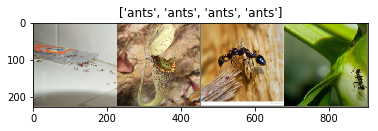

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft.load_state_dict(torch.load('params.pkl'))

#### **读取视频流进行预测**

In [13]:
import numpy as np
from torch.autograd import Variable
import cv2
from PIL import Image


imsize = 224
i = 0

cap = cv2.VideoCapture("C:/Users/gtw/Desktop/Bee Mating Frenzy Ends in Death.mp4")

loader = transforms.Compose([transforms.Resize((imsize, imsize)),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('params.pkl'))
model.eval()

while cap.isOpened():
    ok, frame = cap.read() #读取一帧数据
    if not ok:            
        break  

    image = Image.fromarray(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    
    output = model(image)
    output = nn.functional.softmax(output).detach().numpy()
    print(class_names[np.argmax(output)], ':', np.max(output))


    #显示图像
    i += 1
    if i % 100 == 0:
        print(i)
    cv2.imshow('images', frame)        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

#释放摄像头并销毁所有窗口
cap.release()
cv2.destroyAllWindows() 

c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ants : 0.8406949
ants : 0.81197643
ants : 0.7832156
ants : 0.7754715
ants : 0.77114564
ants : 0.73956645
ants : 0.73384476
ants : 0.71377474
ants : 0.71557236
ants : 0.72758937
ants : 0.7376854
ants : 0.7455738
ants : 0.75857157
ants : 0.7659595
ants : 0.78343827
ants : 0.7862536
ants : 0.7930594
ants : 0.7908243
ants : 0.78617877
ants : 0.7889701
ants : 0.79773515
ants : 0.8142675
ants : 0.8421603
ants : 0.8152802
ants : 0.8477839
ants : 0.8950865
ants : 0.90112936
ants : 0.93547934
ants : 0.61167055
ants : 0.6493935
bees : 0.9448035
ants : 0.5351101
ants : 0.54904157
ants : 0.5296854
bees : 0.73462117
ants : 0.7771632
bees : 0.51186526
bees : 0.72595906
bees : 0.7181063
bees : 0.69096637
bees : 0.8226897
bees : 0.74772567
bees : 0.618717
bees : 0.62808657
bees : 0.6299006
bees : 0.55558085
bees : 0.9089991
bees : 0.7630455
bees : 0.8720008
bees : 0.7787822
bees : 0.7929874
bees : 0.81168807
bees : 0.8820114
bees : 0.82617855
bees : 0.88130075
bees : 0.8429613
bees : 0.8455728
bees : 

**单张用opencv做预测**

In [80]:
imsize = 224
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])
image1 = cv2.imread('hymenoptera_data/val/bees/u=465010482,3300845597&fm=27&gp=0.jpg')
image = Image.fromarray(cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)).convert('RGB')

image = loader(image).float()
image = Variable(image, requires_grad=True)
image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet

model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('params.pkl'))
model.eval()

output = model(image)
output = nn.functional.softmax(output, dim=1).detach().numpy()
print(class_names[np.argmax(output)], ':', np.max(output))

cv2.imshow('image', image1)
cv2.waitKey(100) & 0xFF == ord('q')
cv2.destroyAllWindows() 

ants : 0.77539134


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [76]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)


Epoch 0/9
----------
train Loss: 0.4660 Acc: 0.8197
val Loss: 0.5348 Acc: 0.8235

Epoch 1/9
----------
train Loss: 0.4685 Acc: 0.7992
val Loss: 0.2856 Acc: 0.8954

Epoch 2/9
----------
train Loss: 0.2530 Acc: 0.9016
val Loss: 0.2805 Acc: 0.9085

Epoch 3/9
----------
train Loss: 0.3323 Acc: 0.8156
val Loss: 0.3455 Acc: 0.8562

Epoch 4/9
----------
train Loss: 0.3716 Acc: 0.8156
val Loss: 0.2916 Acc: 0.9150

Epoch 5/9
----------
train Loss: 0.2501 Acc: 0.8934
val Loss: 0.2824 Acc: 0.9020

Epoch 6/9
----------
train Loss: 0.3216 Acc: 0.8484
val Loss: 0.2694 Acc: 0.9085

Epoch 7/9
----------
train Loss: 0.2671 Acc: 0.8934
val Loss: 0.3064 Acc: 0.8954

Epoch 8/9
----------
train Loss: 0.2970 Acc: 0.8811
val Loss: 0.2633 Acc: 0.9281

Epoch 9/9
----------
train Loss: 0.2504 Acc: 0.8852
val Loss: 0.2609 Acc: 0.9281

Training complete in 10m 40s
Best val Acc: 0.928105


In [77]:
torch.save(model_ft.state_dict(), 'params.pkl')

**单张用Image读取预测**

In [79]:
from PIL import Image
from torch.autograd import Variable
import glob

imsize = 224
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('params.pkl'))
model.eval()

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU


image = image_loader('hymenoptera_data/val/bees/20180816101226.jpg')
output = model(image)
output = nn.functional.softmax(output)
print(output)

# _, pre = torch.max(output, 1)
# pre

tensor([[ 0.9304,  0.0696]])


c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


**多张同一个文件夹预测**

In [29]:
from PIL import Image
from torch.autograd import Variable
import glob

imsize = 224
loader = transforms.Compose([transforms.Scale((imsize, imsize)), transforms.ToTensor()])
model_ft.eval()

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    # image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

for i in glob.glob('hymenoptera_data/val/bees/*.jpg'):
    image = image_loader(i)
    output = model_ft(image)
    output = nn.functional.softmax(output)
    if output[0][1] > output[0][0]:
        print(i, output)
# _, pre = torch.max(output, 1)
# pre
    

c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


hymenoptera_data/val/bees\1181173278_23c36fac71.jpg tensor([[ 0.3388,  0.6612]])
hymenoptera_data/val/bees\1297972485_33266a18d9.jpg tensor([[ 0.0638,  0.9362]])
hymenoptera_data/val/bees\1328423762_f7a88a8451.jpg tensor([[ 0.2031,  0.7969]])
hymenoptera_data/val/bees\144098310_a4176fd54d.jpg tensor([[ 0.0503,  0.9497]])
hymenoptera_data/val/bees\151594775_ee7dc17b60.jpg tensor([[ 0.3235,  0.6765]])
hymenoptera_data/val/bees\1519368889_4270261ee3.jpg tensor([[ 0.1934,  0.8066]])
hymenoptera_data/val/bees\152789693_220b003452.jpg tensor([[ 0.4863,  0.5137]])
hymenoptera_data/val/bees\177677657_a38c97e572.jpg tensor([[ 0.0679,  0.9321]])
hymenoptera_data/val/bees\1799729694_0c40101071.jpg tensor([[ 0.1459,  0.8541]])
hymenoptera_data/val/bees\181171681_c5a1a82ded.jpg tensor([[ 0.1040,  0.8960]])
hymenoptera_data/val/bees\203868383_0fcbb48278.jpg tensor([[ 0.3970,  0.6030]])
hymenoptera_data/val/bees\2060668999_e11edb10d0.jpg tensor([[ 0.1121,  0.8879]])
hymenoptera_data/val/bees\20862947

In [61]:
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


model_ft = models.resnet152(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)
model_ft.eval()
output = model_ft(image_loader(data_transforms, './hymenoptera_data/val/ants/10308379_1b6c72e180.jpg')).detach()
output = nn.functional.softmax(output).numpy()
print( output, np.argmax(output))

[[0.6927343  0.30726573]] 0


c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
visualize_model(model_ft)

In [51]:
from PIL import Image

data = Image.open('./hymenoptera_data/val/ants/10308379_1b6c72e180.jpg').convert('RGB')
# data = data.resize((224,224))

data = np.array(data)
data = data.transpose(2,0,1)
data = np.expand_dims(data, axis=0)
print(data.shape)
tensor = torch.from_numpy(data)
# tensor = tensor.unsqueeze(dim=0)
tensor = tensor.float()

(1, 3, 375, 500)


In [40]:
from torch import nn
import torch.nn.functional as F

# softmax = nn.Softmax()
output = model_ft(tensor)
pre = F.softmax(output)
class_names = image_datasets['train'].class_to_idx
print(output, pre, class_names)

tensor([[ 27.2925, -15.9429]]) tensor([[ 1.0000e+00,  1.6715e-19]]) {'ants': 0, 'bees': 1}


c:\users\gtw\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()